In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression 

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("gold_monthly_csv.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [7]:
df.shape

(847, 2)

In [8]:
print(f"Data range of gold prices avalible from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")


Data range of gold prices avalible from - 1950-01 to 2020-07


In [9]:
date = pd.date_range(start = '1/1/1950', end = '8/1/2020', freq ='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='ME')

In [10]:
df['month']=date
df.drop('Date', axis =1, inplace = True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


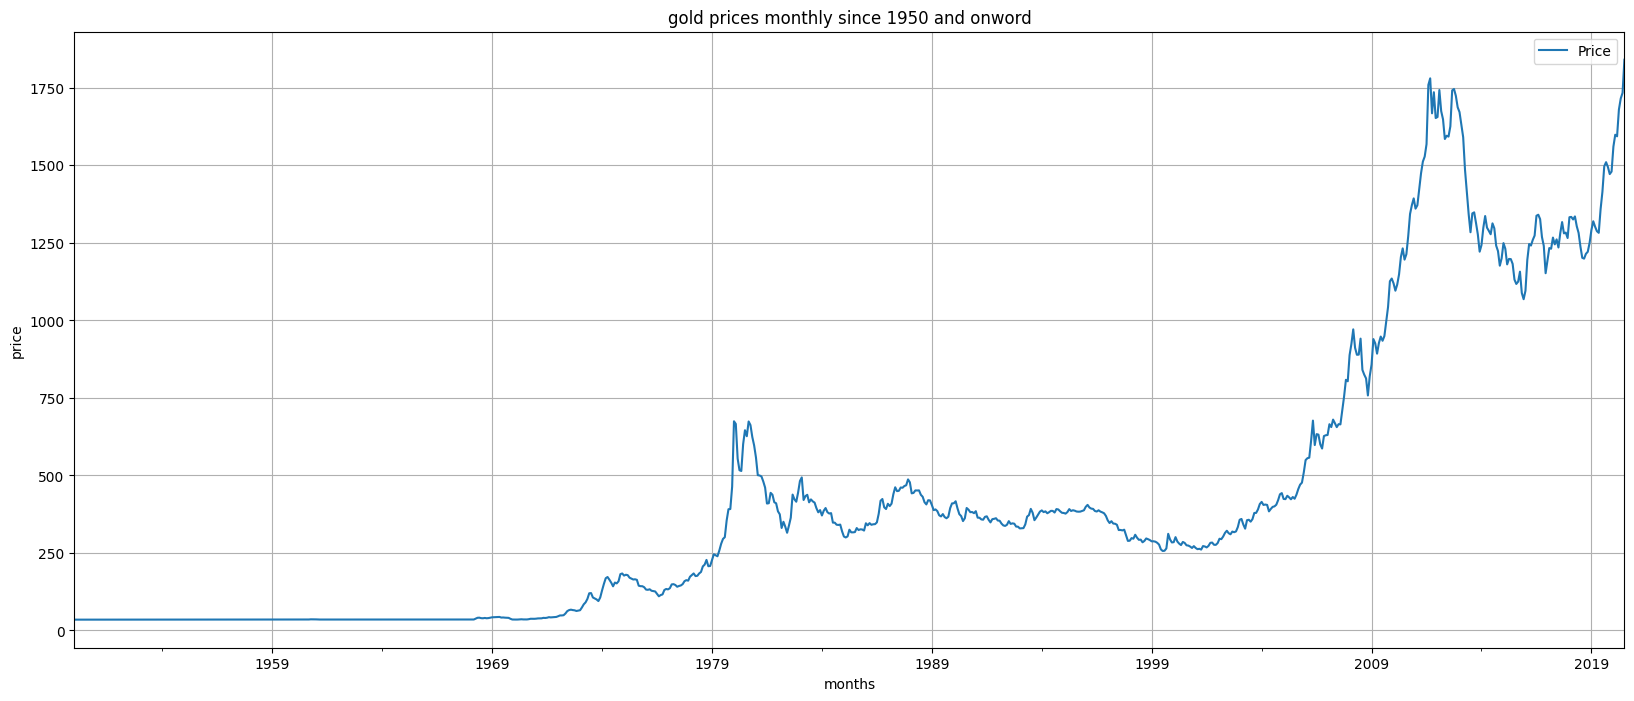

In [11]:
df.plot(figsize=(20,8))
plt.title("gold prices monthly since 1950 and onword")
plt.xlabel("months")
plt.ylabel("price")
plt.grid();

In [12]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


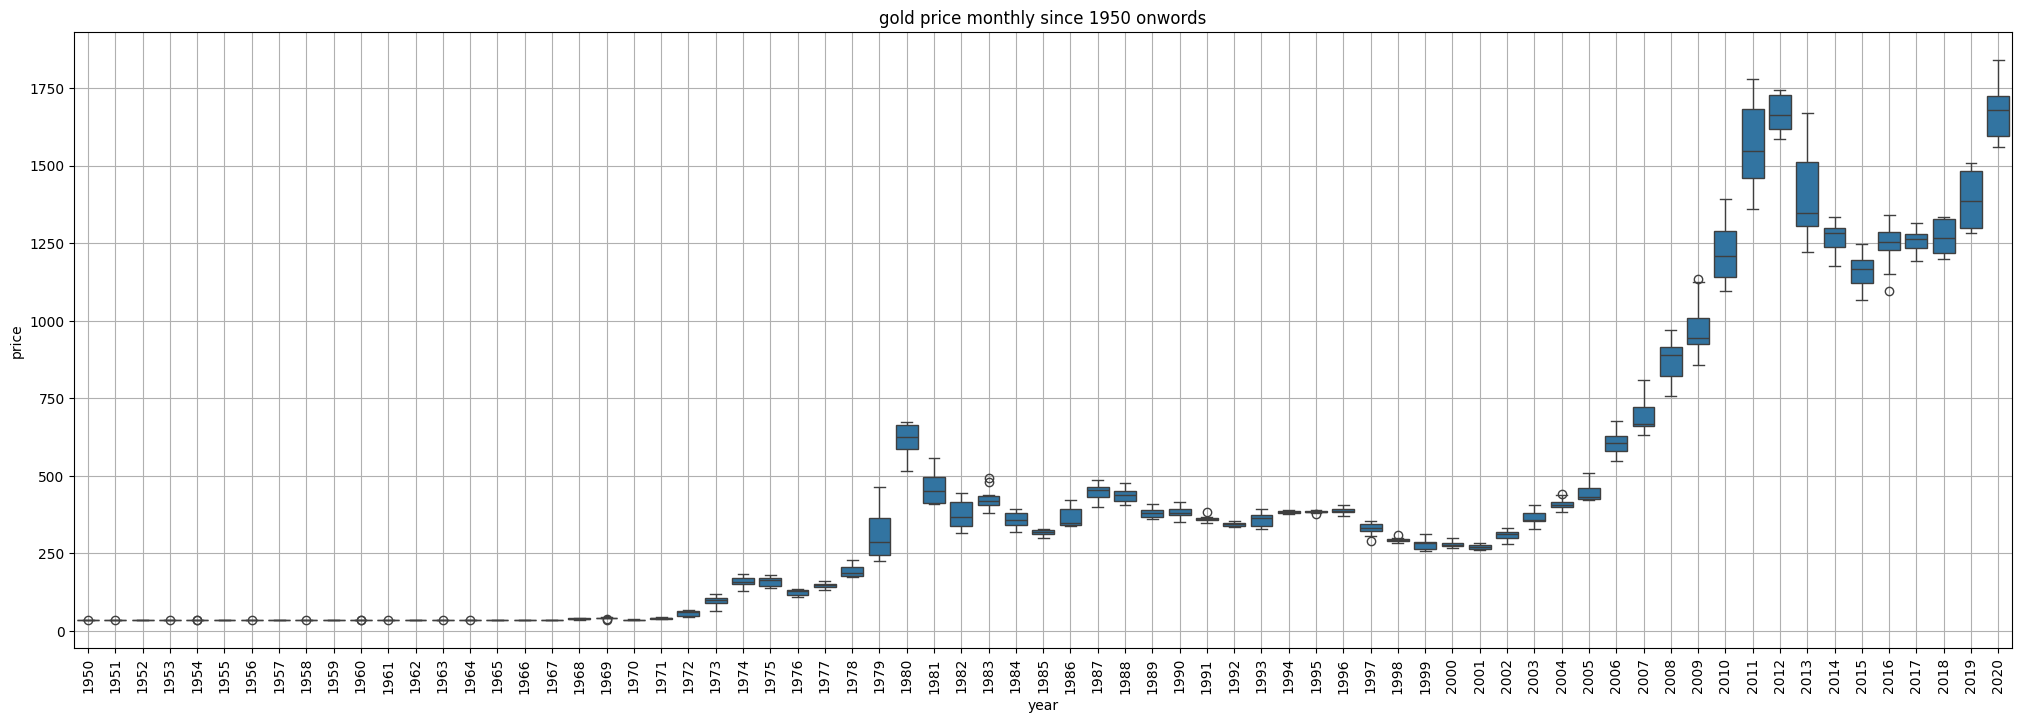

In [13]:
_,ax =plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year,y=df.values[:,0],ax=ax)
plt.title('gold price monthly since 1950 onwords')
plt.xlabel('year')
plt.ylabel('price')
plt.xticks(rotation = 90)
plt.grid();

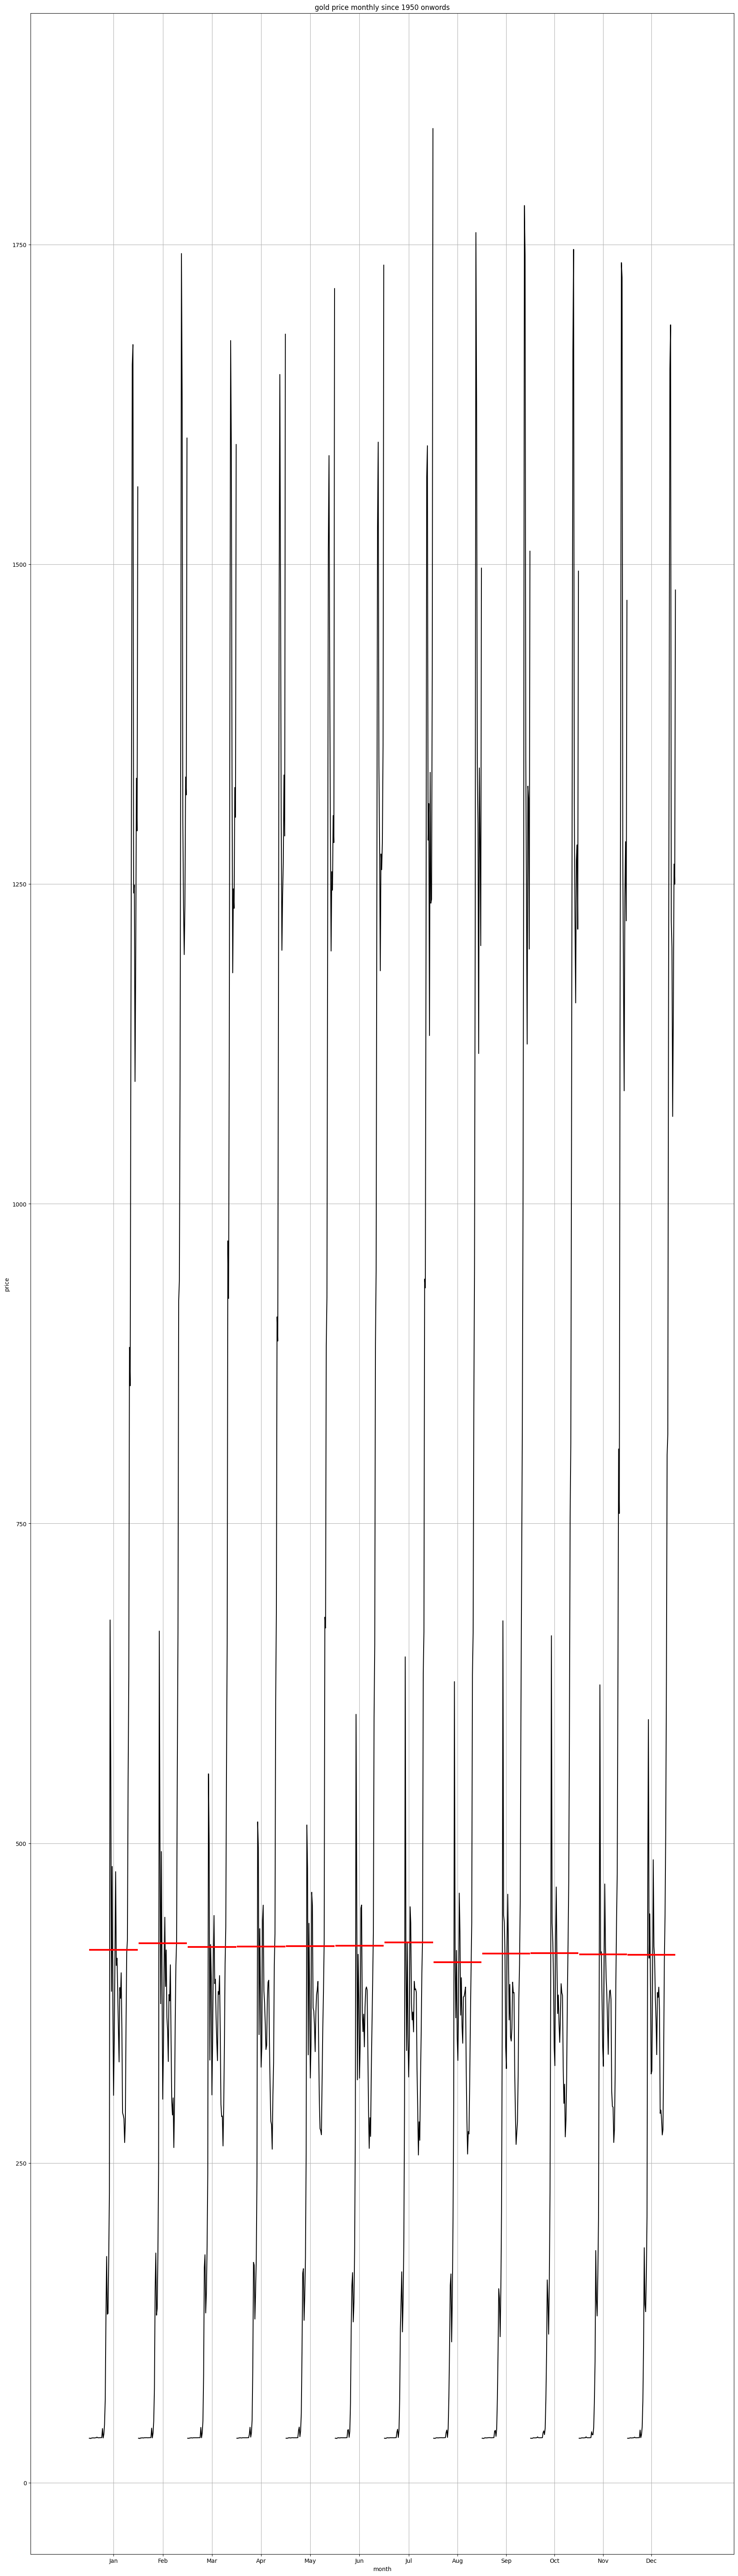

In [14]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax=plt.subplots(figsize = (22,80))
month_plot(df,ylabel ='gold price',ax = ax)
plt.title('gold price monthly since 1950 onwords')
plt.xlabel('month')
plt.ylabel('price')
plt.grid()

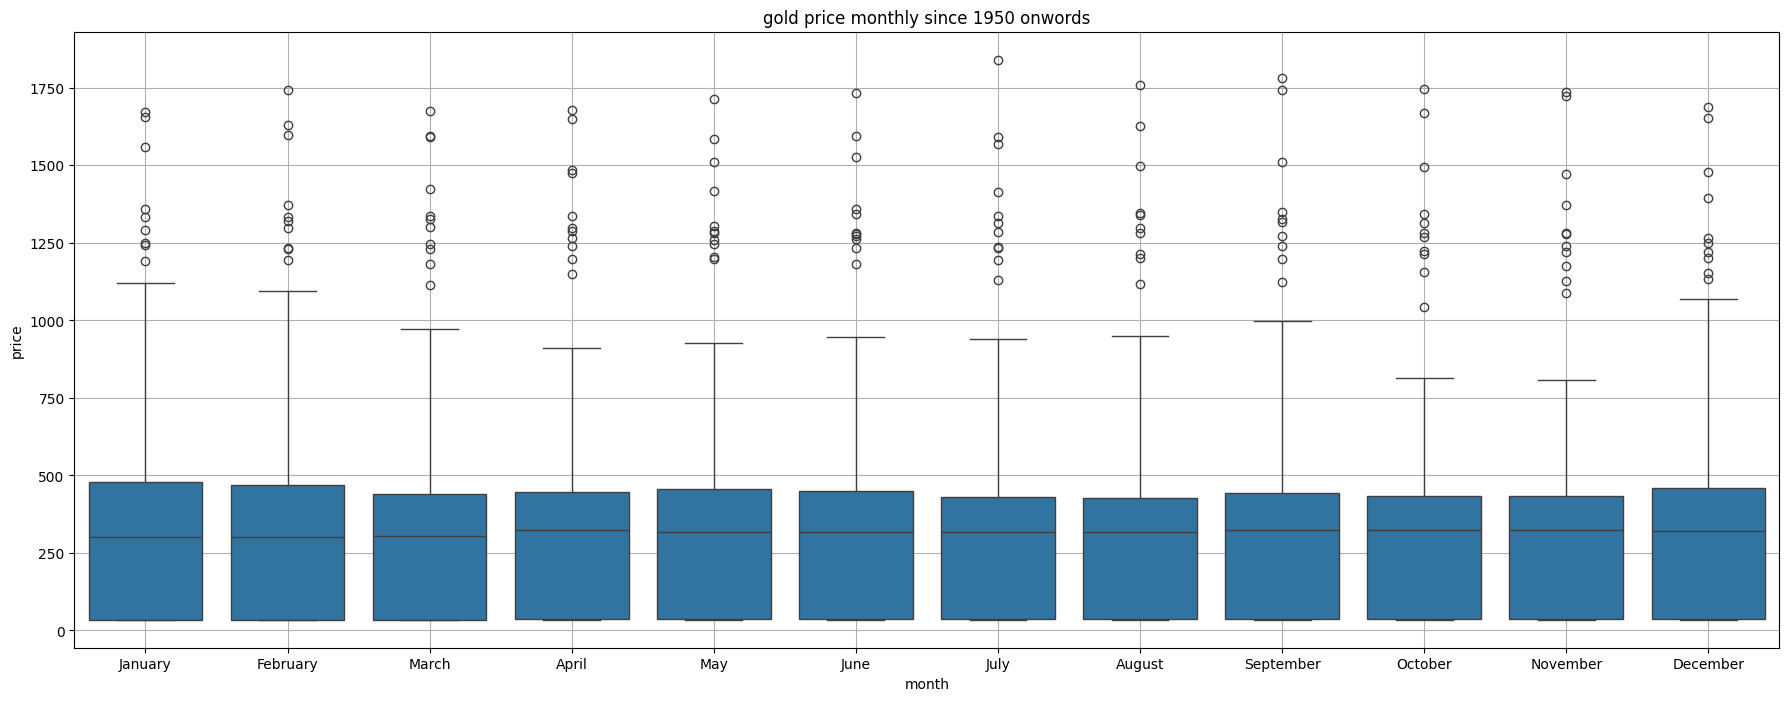

In [15]:
_, ax= plt.subplots(figsize = (22,8))
sns.boxplot(x = df.index.month_name(),y=df.values[:,0], ax=ax)
plt.title('gold price monthly since 1950 onwords')
plt.xlabel('month')
plt.ylabel('price')
plt.grid()

In [18]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [19]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


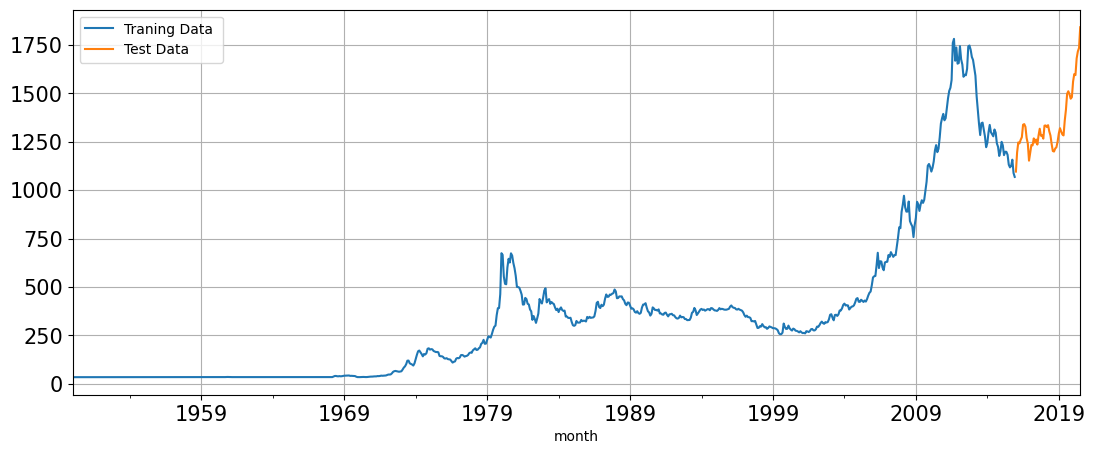

In [22]:
train["Price"].plot(figsize=(13,5), fontsize =15)
test["Price"].plot(figsize=(13,5),fontsize = 15)
plt.grid()
plt.legend(['Traning Data ','Test Data'])

In [25]:
train_time =[i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(792, 55)

In [26]:
LR_train = train.copy()
LR_test = test.copy()

In [28]:
LR_train['time']=train_time
LR_test['time'] =test_time

In [30]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train["Price"].values)

LinearRegression()

<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

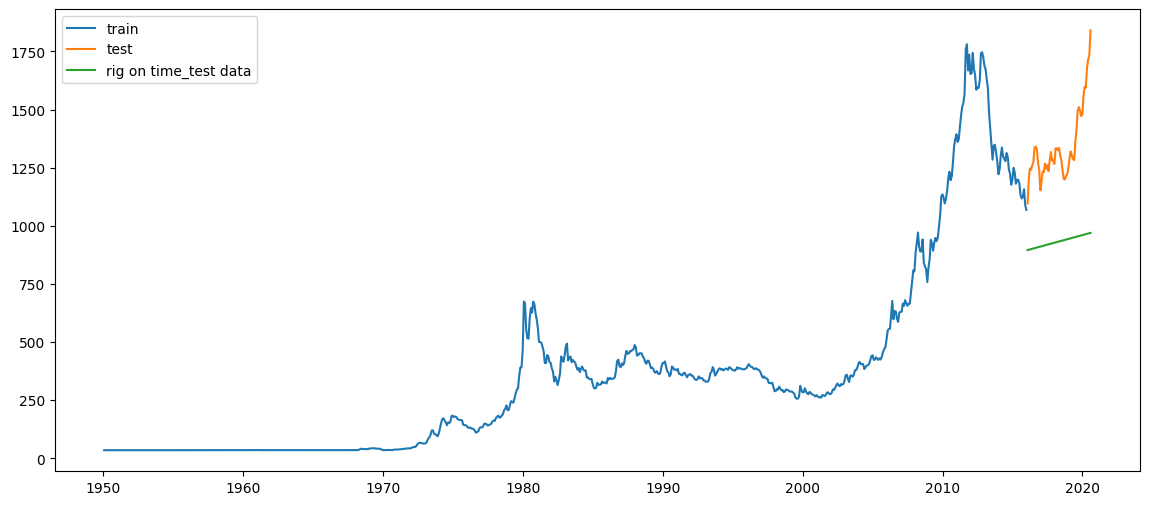

In [39]:
test_predictions_model1=lr.predict(LR_test[["time"]])
LR_test["forecast"]=test_predictions_model1

plt.figure(figsize = (14,6))
plt.plot(train["Price"], label = 'train')
plt.plot(test["Price"], label = 'test')
plt.plot(LR_test["forecast"], label = 'rig on time_test data')
plt.legend(loc = "best")
plt.grid

In [41]:
def mape(actual,pred):
    return round((np.mean(abs(actual -pred)/actual))*100,2)

In [42]:
mape_model1_test =mape(test['Price'].values,test_predictions_model1)
print("MAPE is %3.3f"%(mape_model1_test),"%")

MAPE is 29.760 %


In [50]:
results = pd.DataFrame({"Test mape(%)":[mape_model1_test]}, index = ["RegressionONTime"])
results

,Test mape(%)
RegressionONTime,29.76


In [52]:
final_model= ExponentialSmoothing(df,trend ='additive',seasonal ='additive').fit(smoothing_level =0.4,
                                                                                 smoothing_trend =0.3,
                                                                                 smoothing_seasonal = 0.6)
       

In [54]:
Mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print("MAPE:",Mape_final_model)

MAPE: 17.24


In [55]:
predictions =final_model.forecast(steps=len(test))

In [58]:
pred_df =pd.DataFrame({'lower_CI':predictions - 1.96*np.std(final_model.resid,ddof =1),
                       'prediction':predictions,
                       'upper_CI':predictions+ 1.96*np.std(final_model.resid,ddof =1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.719922,1792.870894,1901.021866
2020-09-30,1615.305634,1723.456606,1831.607579
2020-10-31,1538.567122,1646.718094,1754.869067
2020-11-30,1476.757432,1584.908404,1693.059376
2020-12-31,1459.325790,1567.476763,1675.627735


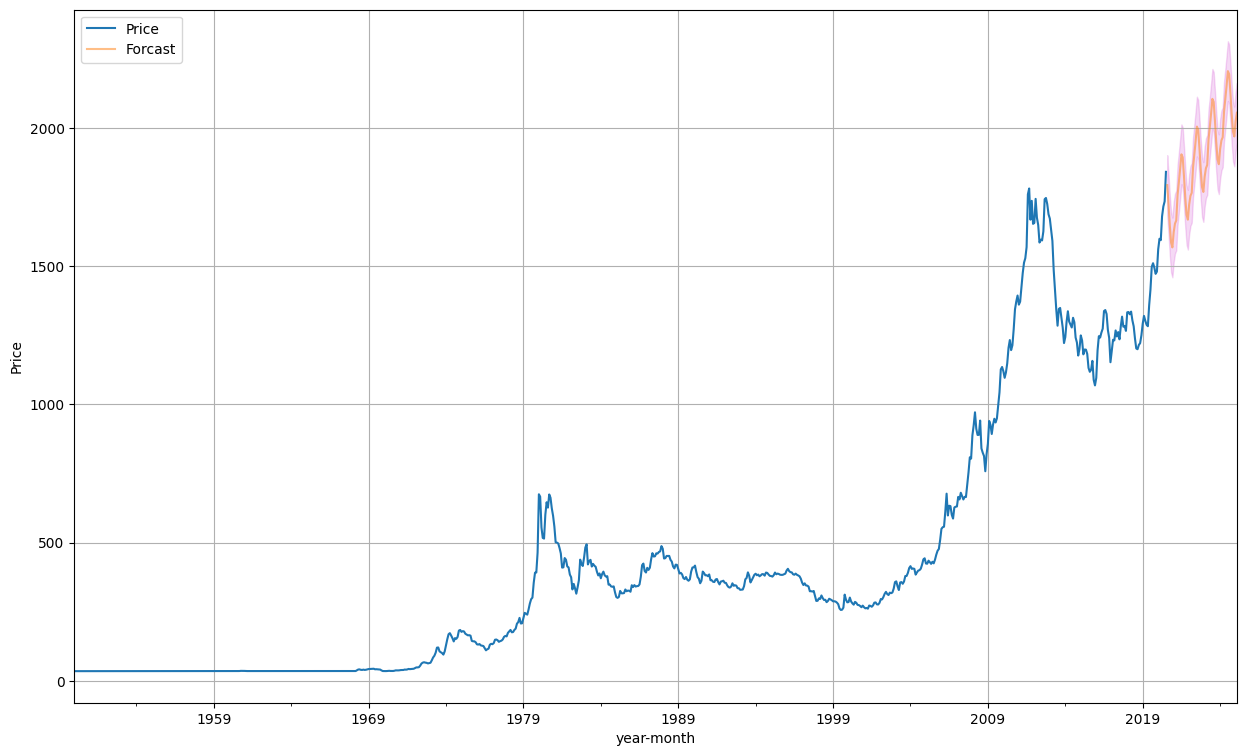

In [70]:
axis = df.plot(label = "Actual",figsize=(15,9))
pred_df['prediction'].plot(ax = axis,label = 'Forcast', alpha = 0.5)
axis.fill_between(pred_df.index,pred_df["lower_CI"], pred_df["upper_CI"], color ="m", alpha =.15)
axis.set_xlabel("year-month")
axis.set_ylabel("Price")
plt.legend(loc ="best")
plt.grid()
plt.show()